# Schrödinger Bridge via a Brownian Bridge (1D)

This notebook accompanies **Chapter 9 / Section 9.2 (Bridge Diffusion)**.

Goal:
- Contrast **unconstrained diffusion** (forward Brownian motion) with a **bridge diffusion** that is conditioned to hit a prescribed endpoint at final time.
- Visualize (i) **sample trajectories** and (ii) **time-evolving marginals**.

We use a pedagogical setting where the *bridge term is available in closed form*: a **Brownian bridge**.  
This is a concrete instance of the **Doob $h$-transform** viewpoint.

All figures are saved to a `figs/` subdirectory.

In [1]:
# Imports and utilities
import os
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
rng = np.random.default_rng(0)

# Create figs/ subdirectory (relative to notebook working directory)
FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)

def savefig(fname, dpi=200):
    path = os.path.join(FIG_DIR, fname)
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"Saved: {path}")

## Problem setup

We define:
- an **initial distribution**: a symmetric mixture of Gaussians (bimodal),
- a **terminal distribution**: a single Gaussian.

We then compare two processes over a finite horizon $t\in[0,T]$:
1. **Unconstrained diffusion:** Brownian motion with variance parameter $\sigma^2$.
2. **Bridge diffusion:** Brownian bridge that is conditioned to end at a sampled terminal point $x_T$.

In this simple setting, the bridge drift is explicit:
\[
dX_t = \frac{x_T - X_t}{T-t}\,dt + \sigma\,dW_t,
\]
which is the Doob-transform drift corresponding to conditioning on the endpoint.

In [2]:
# Distributions and simulation parameters
T = 1.0
n_steps = 200
dt = T / n_steps
ts = np.linspace(0.0, T, n_steps + 1)

sigma = 0.6  # diffusion scale

# Initial distribution: mixture of Gaussians
mu0 = np.array([-2.0, 2.0])
std0 = 0.35
mix_prob = np.array([0.5, 0.5])

# Terminal distribution: single Gaussian
muT = 0.0
stdT = 0.45

def sample_initial(n):
    comp = rng.choice(len(mu0), size=n, p=mix_prob)
    return rng.normal(loc=mu0[comp], scale=std0, size=n)

def sample_terminal(n):
    return rng.normal(loc=muT, scale=stdT, size=n)

# Simulation batch sizes
n_paths_viz = 25      # trajectories to plot
n_paths_marg = 20000  # for marginal density snapshots

print("Setup:")
print(f"T={T}, steps={n_steps}, dt={dt:.4g}, sigma={sigma}")

Setup:
T=1.0, steps=200, dt=0.005, sigma=0.6


## Simulating unconstrained diffusion (Brownian motion)

We simulate:
\[
X_{t+\Delta t} = X_t + \sigma \sqrt{\Delta t}\,\xi,\qquad \xi\sim\mathcal N(0,1).
\]

This process does *not* enforce any terminal constraint; it simply spreads mass over time.

In [3]:
def simulate_brownian(x0, n_steps, dt, sigma):
    # x0: shape (n_paths,)
    n = x0.shape[0]
    X = np.empty((n, n_steps + 1), dtype=float)
    X[:, 0] = x0
    noise = rng.normal(size=(n, n_steps))
    X[:, 1:] = x0[:, None] + sigma * np.sqrt(dt) * np.cumsum(noise, axis=1)
    return X

# Trajectories for visualization
x0_viz = sample_initial(n_paths_viz)
X_bm_viz = simulate_brownian(x0_viz, n_steps, dt, sigma)

## Simulating bridge diffusion (Brownian bridge)

We condition on endpoints by first sampling $x_T$ from the terminal distribution, then simulating:

$$
X_{t+\Delta t}
=
X_t
+
\frac{x_T - X_t}{T-t}\,\Delta t
+
\sigma \sqrt{\Delta t}\,\xi.
$$

This is the simplest “bridge diffusion” and directly illustrates the role of an added drift that *steers* the trajectories.

In [4]:
def simulate_brownian_bridge(x0, xT, ts, sigma):
    # x0, xT: shape (n_paths,)
    n = x0.shape[0]
    n_steps = len(ts) - 1
    dt = ts[1] - ts[0]
    X = np.empty((n, n_steps + 1), dtype=float)
    X[:, 0] = x0

    for k in range(n_steps):
        t = ts[k]
        denom = max(T - t, 1e-8)  # avoid divide-by-zero at final step
        drift = (xT - X[:, k]) / denom
        X[:, k+1] = X[:, k] + drift * dt + sigma * np.sqrt(dt) * rng.normal(size=n)
    return X

# Trajectories for visualization
x0b_viz = sample_initial(n_paths_viz)
xTb_viz = sample_terminal(n_paths_viz)
X_bridge_viz = simulate_brownian_bridge(x0b_viz, xTb_viz, ts, sigma)

## Figure 1: Two-panel diagnostic

- **Left:** Unconstrained diffusion vs bridge diffusion trajectories (same time axis).
- **Right:** Endpoint behavior: the bridge trajectories concentrate near their conditioned endpoints.

Saved: figs/schrbridge_trajectories.png


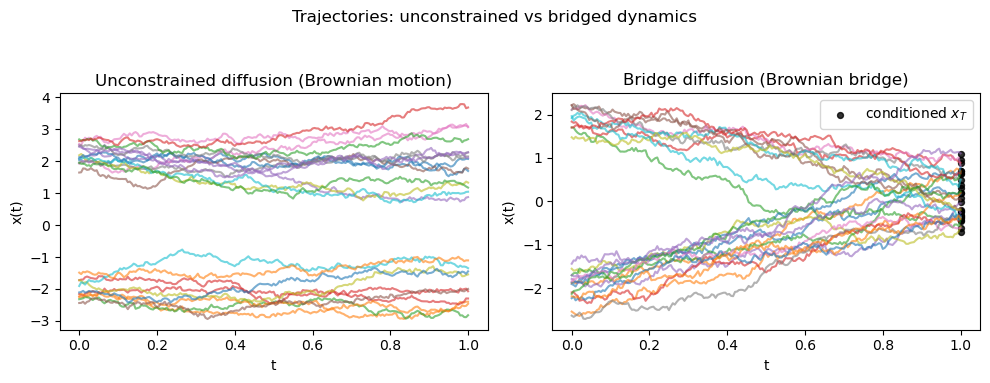

In [5]:
plt.figure(figsize=(10, 3.6))

# Left panel: trajectories
plt.subplot(1, 2, 1)
for i in range(n_paths_viz):
    plt.plot(ts, X_bm_viz[i], alpha=0.6)
plt.title("Unconstrained diffusion (Brownian motion)")
plt.xlabel("t")
plt.ylabel("x(t)")

# Right panel: bridge trajectories
plt.subplot(1, 2, 2)
for i in range(n_paths_viz):
    plt.plot(ts, X_bridge_viz[i], alpha=0.6)
plt.scatter(np.full(n_paths_viz, T), xTb_viz, s=18, color="black", alpha=0.8, label="conditioned $x_T$")
plt.title("Bridge diffusion (Brownian bridge)")
plt.xlabel("t")
plt.ylabel("x(t)")
plt.legend(loc="best", frameon=True)

plt.suptitle("Trajectories: unconstrained vs bridged dynamics", y=1.05)
plt.tight_layout()
savefig("schrbridge_trajectories.png")
plt.show()

## Time-evolving marginals

We next visualize the time-marginal distributions at several snapshots.
For each snapshot time $t_k$, we aggregate many simulated paths and display histograms (as density estimates).

This highlights the core conceptual difference:
- Brownian motion **spreads** and does not target a terminal distribution.
- The bridge process **reallocates mass** so that $X_T$ matches the prescribed terminal law.

In [6]:
# Simulate many paths for marginal snapshots
x0_m = sample_initial(n_paths_marg)
X_bm = simulate_brownian(x0_m, n_steps, dt, sigma)

x0_m2 = sample_initial(n_paths_marg)
xT_m2 = sample_terminal(n_paths_marg)
X_br = simulate_brownian_bridge(x0_m2, xT_m2, ts, sigma)

# Snapshot indices
snap_ts = [0.0, 0.25, 0.5, 0.75, 1.0]
snap_idx = [int(t / dt) for t in snap_ts]

# Plot settings
xmin, xmax = -5.0, 5.0
bins = 120

## Figure 2: Multi-panel marginals (Brownian vs bridge)

We show the marginal densities at the same set of times for both processes.
This is the simplest visualization of endpoint conditioning as a **global constraint** implemented via a **local drift**.

Saved: figs/schrbridge_marginals.png


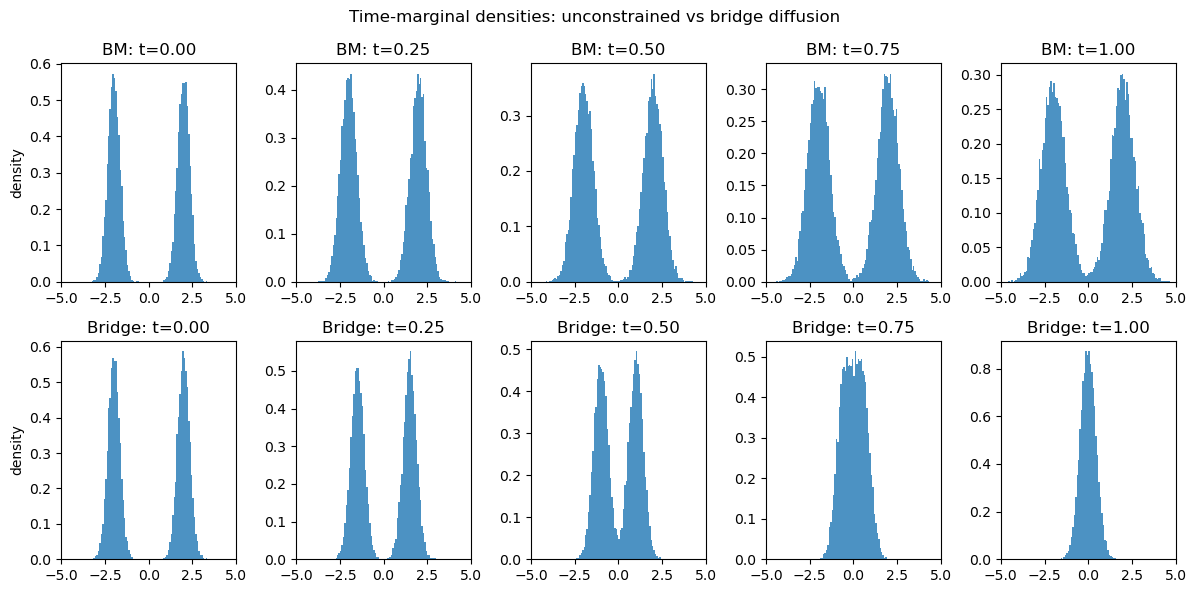

In [7]:
plt.figure(figsize=(12, 6))

for j, idx in enumerate(snap_idx):
    # Brownian motion marginals
    plt.subplot(2, len(snap_idx), j + 1)
    plt.hist(X_bm[:, idx], bins=bins, range=(xmin, xmax), density=True, alpha=0.8)
    plt.title(f"BM: t={snap_ts[j]:.2f}")
    plt.xlim(xmin, xmax)
    if j == 0:
        plt.ylabel("density")

    # Bridge marginals
    plt.subplot(2, len(snap_idx), len(snap_idx) + j + 1)
    plt.hist(X_br[:, idx], bins=bins, range=(xmin, xmax), density=True, alpha=0.8)
    plt.title(f"Bridge: t={snap_ts[j]:.2f}")
    plt.xlim(xmin, xmax)
    if j == 0:
        plt.ylabel("density")

plt.suptitle("Time-marginal densities: unconstrained vs bridge diffusion", y=0.98)
plt.tight_layout()
savefig("schrbridge_marginals.png")
plt.show()

## Discussion and connections

1. **Doob $h$-transform interpretation:** the bridge drift is the gradient of a log-transition density, i.e. an *endpoint-conditioning score*.
2. **Finite-horizon exactness:** unlike standard diffusion relying on $T\to\infty$, bridge diffusion enforces the terminal law at finite $T$.
3. **Bridge to later sections:** this endpoint-conditioning drift can be reinterpreted as a **control field**, connecting Schrödinger bridges to stochastic optimal control and path-integral formulations.

## Bridge drift field (Doob conditioning made visible)

For the Brownian bridge used in this notebook, the conditioned dynamics take the form
\[
dX_t = \frac{x_T - X_t}{T-t}\,dt + \sigma\,dW_t,
\]
so the **bridge drift** is the guidance field
\[
u(x,t; x_T) = \frac{x_T - x}{T-t}.
\]

To visualize how endpoint conditioning manifests as a time-dependent force,
we plot $u(x,t;x_T)$ as a function of $x$ at several times $t$, for a few
representative terminal values $x_T$ (centered at the mean of the terminal
distribution used above).


Saved: figs/schrbridge_drift_field.png


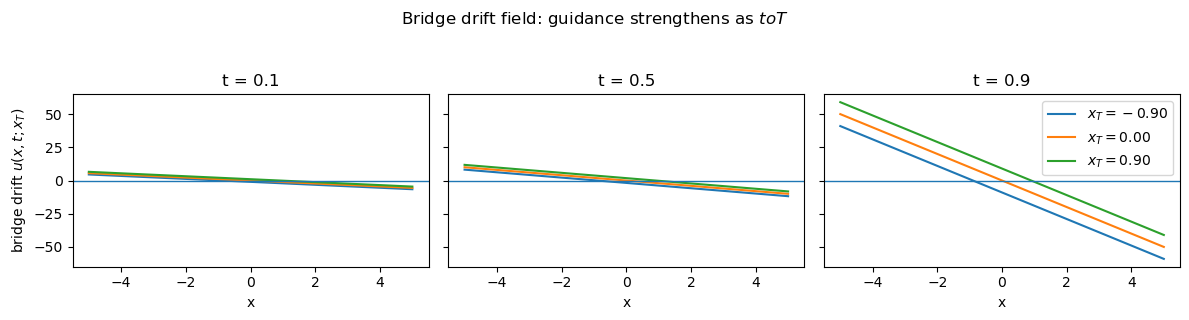

In [8]:
# Bridge drift field visualization (Brownian bridge)
import numpy as np
import matplotlib.pyplot as plt

# Spatial grid for the drift field
xs = np.linspace(-5, 5, 500)

# Times at which we visualize the drift
times = [0.1, 0.5, 0.9]

# Representative terminal values (center and ±2 std)
xT_vals = [muT - 2*stdT, muT, muT + 2*stdT]

fig, axes = plt.subplots(1, len(times), figsize=(12, 3), sharey=True)

for ax, t in zip(axes, times):
    denom = max(T - t, 1e-8)
    for xT in xT_vals:
        drift = (xT - xs) / denom
        ax.plot(xs, drift, label=f"$x_T={xT:.2f}$")
    ax.axhline(0.0, linewidth=1)
    ax.set_title(f"t = {t}")
    ax.set_xlabel("x")

axes[0].set_ylabel(r"bridge drift $u(x,t;x_T)$")
axes[-1].legend(loc="best", frameon=True)

plt.suptitle("Bridge drift field: guidance strengthens as $t\to T$", y=1.05)
plt.tight_layout()
savefig("schrbridge_drift_field.png")
plt.show()
